In [1]:
import gym
from tqdm.notebook import trange, tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle
import time
from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple, defaultdict
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (14,6)
legend_fontsize = 16

In [2]:
N_ROWS, N_COLS, N_WIN, GAMMA = 3, 3, 3, 1

Итак, играет Крестик и Нолик, Нолик пытается минимизировать награду, а Крестик максимизировать. Когда Крестик делает невалидное действие (актуально для нейронок, но не Q-обучения) - штрафуем его, ставим -3, когда Нолик делает невалидное действие - ставим +3.

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            # чтобы нейронная сеть не совершала невалидных действий играя за Нолика
            reward = -3 if self.curTurn == 1 else 3
            return self.getState(), reward, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi(s, env.curTurn, len(actions))

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
    
        print(a)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [6]:
env = TicTacToe()

In [7]:
def decay_epsilon_gen(min_epsilon=.01, decay=0.99999):
    epsilon = 1
    while epsilon > min_epsilon:
        yield epsilon
        epsilon = epsilon*decay
    while True:
        yield min_epsilon
        
def const_gen(epsilon):
    while True:
        yield epsilon

Лично мне интересно, что будет, если один делает чистый exploration (epsilon=1), а другой играет эпсилон мягкую. Также интересно посмотреть как стратегия будет играть сама против себя. Логично предположить, что придут к ничье. 'x' будет максимизировать награду, а 'o'  - минимизировать. Само обучение можно построить по-разному: 1) Обучать через ход. То есть обучаем крестики после того как походят нолики. Тогда две стратегии будут обучаться независимо. 2). Обучать всех вместе мне кажется более выигрышным, то есть стратегия независимо от exploration-a учится обыгрывать сама себя. Если полагать, что статегия стремится к оптимальности, то выигрывать оптимальную стратегию интереснее, чем другие, поэтому я выбрал второй вариант для реализации

In [8]:
class Policy:
    def __init__(self, learning_rate=.1):
        self.Q = dict()
        self.lr = learning_rate
        
    def __call__(self, s, player, n_a, epsilon=0): # call greedy policy to pick an action
        if s not in self.Q:
            self.Q[s] = np.zeros(n_a, dtype=np.float32) - 1e-5
        # вероятность epsilon выбрать случайное действие
        if epsilon and np.random.random() < epsilon:
            a = np.random.randint(0, n_a)
        else:
            a = np.argmax(self.Q[s]) if player == 1 else np.argmin(self.Q[s])
        return a
    
    def learn(self, s, player, a, n_a, reward, s_next, done):            
        if s not in self.Q:
            self.Q[s] = np.zeros(n_a, dtype=np.float32)
        # если s_next - терминальная то у нее есть награда и нет Qmax
        if done:
            self.Q[s][a] += self.lr *(reward - self.Q[s][a])
        else:
            if s_next in self.Q:
                Q_max = np.min(self.Q[s_next]) if player == 1 else np.max(self.Q[s_next])
            else: # впервые в состоянии, еще не известно Q_max
                Q_max = - 1e-5
                
            self.Q[s][a] += self.lr * (GAMMA*Q_max - self.Q[s][a])
            
def play_episode(pi, eps_x, eps_o):
    env.reset()
    done = False
    s = env.getHash()
    while not done:
        actions = env.getEmptySpaces()
        n_a = len(actions)
        player = env.curTurn
        if player == 1:
            a = pi(s, player, n_a, eps_x)
        else:
            a = pi(s, player, n_a, eps_o)
        observation, reward, done, info = env.step(actions[a])
        s_prev, s = s, env.getHash()
        
        if player == 1:
            pi.learn(s_prev, player, a, n_a, reward, s, done)
        else:
            pi.learn(s_prev, player, a, n_a, reward, s, done)
    return reward

def plot_reward(lines, legend=None):
    plt.rcParams["font.size"] = "16" 
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor("seashell")
    plt.ylabel("mean reward")
    plt.xlabel("iteration")
    for x,y in lines:
        plt.plot(x, y)
    ax.set_yticks([-1, -0.75, -.5, -.25, -0, .25, .5, 0.75, 1])
    if legend is not None:
        ax.legend(legend)
    ax.grid(); plt.grid()
    plt.show()
    
def play_n_games(pi, x_ticks, eps_x, eps_o):
    mean_rewards = []
    running_reward = 0
    n_games = 0
    for i in trange(1, x_ticks[-1]+1):
        a = next(eps_x)
        b = next(eps_o)
        running_reward += play_episode(pi, a, b)
        n_games += 1
        if i in x_ticks:
            mean_rewards.append(running_reward / n_games)
            n_games = 0
            running_reward = 0
    return mean_rewards

In [9]:
# точки для графика, давайте сыграем почти миллион игр
x = (np.logspace(3, 6, 30).astype(np.int32) - 10**3)[1:]
print(x)

[   268    610   1043   1592   2290   3175   4298   5723   7531   9826
  12738  16433  21122  27072  34622  44203  56361  71789  91367 116210
 147735 187739 238502 302919 384662 488390 620016 787046 999000]


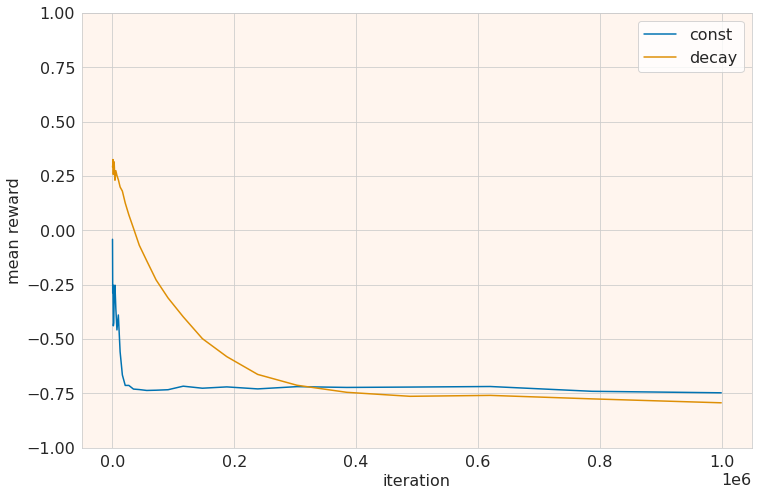

In [10]:
# посмотрим за сколько игр обучится только Нолик (Крестик ходит случайно)
pi = Policy()
mean_rewards_o_const = play_n_games(pi, x, const_gen(1), const_gen(.05))

pi = Policy()
mean_rewards_o_decay = play_n_games(pi, x, const_gen(1), decay_epsilon_gen())

plot_reward([(x, mean_rewards_o_const), (x, mean_rewards_o_decay)], ['const', 'decay'])

[ 128  274  438  623  832 1069 1335 1636 1976 2359 2792 3281 3832 4455
 5158 5951 6847 7858 9000]


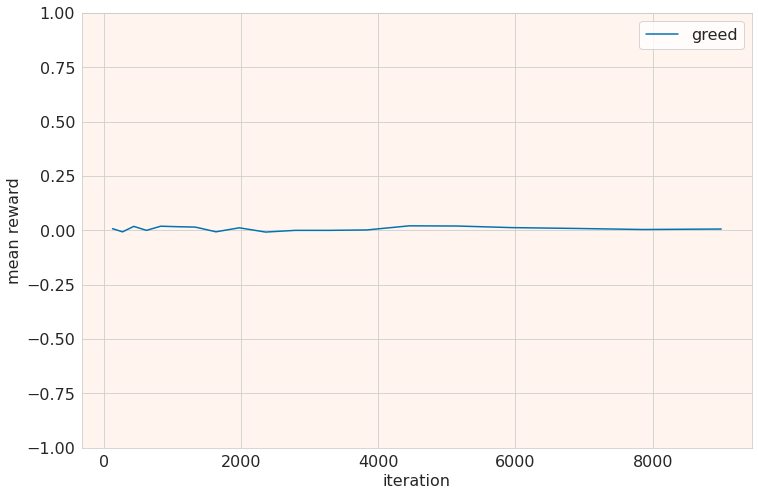

In [12]:
# посмотрим как будут играть оба вжадную на том что обучили (decay)
x = (np.logspace(3, 4, 20).astype(np.int32) - 10**3)[1:]
print(x)
mean_rewards_xo_greed = play_n_games(pi, x, const_gen(.01), const_gen(.01))

plot_reward([(x, mean_rewards_xo_greed)], ['greed'])

Прелесть off-policy: независимо от используемой стратегии, все обучились играть хорошо.

[  172   373   610   887  1212  1592  2039  2562  3175  3893  4736  5723
  6880  8236  9826 11689 13873 16433 19433 22950 27072 31903 37566 44203
 51983 61101 71789 84316 99000]


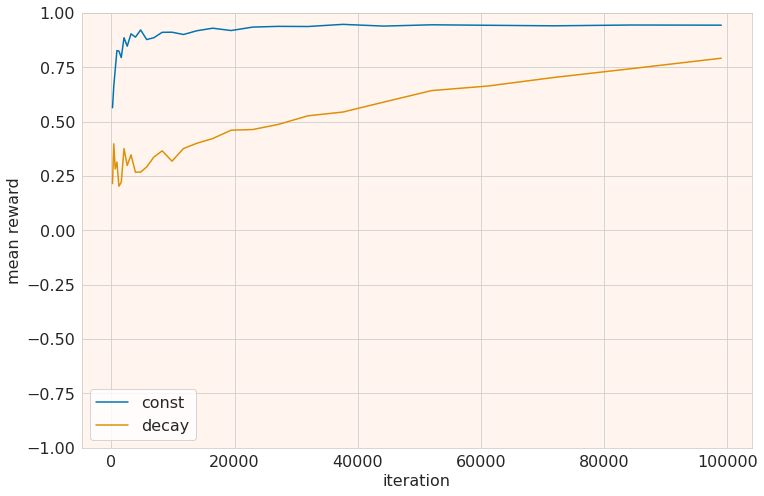

In [13]:
# теперь пробуем всё наоборот, Нолик ходит случайно, а Крестик - жадина
x = (np.logspace(3, 5, 30).astype(np.int32) - 10**3)[1:]
print(x)

pi = Policy()
mean_rewards_x_const = play_n_games(pi, x, const_gen(.05), const_gen(1))

pi = Policy()
mean_rewards_x_decay = play_n_games(pi, x, decay_epsilon_gen(), const_gen(1))

plot_reward([(x, mean_rewards_x_const), (x, mean_rewards_x_decay)], ['const', 'decay'])

[ 128  274  438  623  832 1069 1335 1636 1976 2359 2792 3281 3832 4455
 5158 5951 6847 7858 9000]


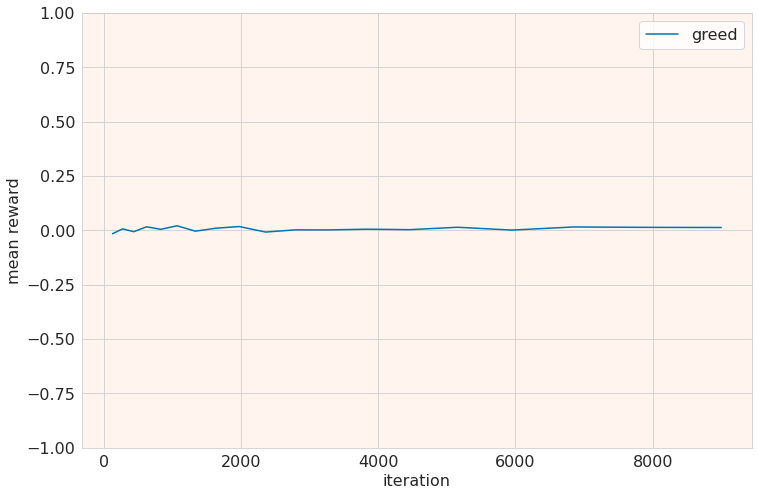

In [14]:
# и посмотрим как будут играть оба вжадную на том что обучили (decay)
x = (np.logspace(3, 4, 20).astype(np.int32) - 10**3)[1:]
print(x)
mean_rewards_xo_greed = play_n_games(pi, x, const_gen(.01), const_gen(.01))

plot_reward([(x, mean_rewards_xo_greed)], ['greed'])

[   268    610   1043   1592   2290   3175   4298   5723   7531   9826
  12738  16433  21122  27072  34622  44203  56361  71789  91367 116210
 147735 187739 238502 302919 384662 488390 620016 787046 999000]


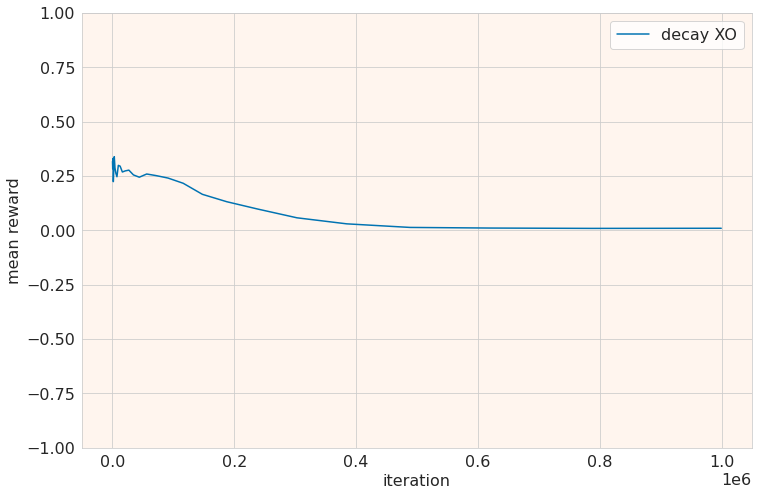

In [18]:
# напоследок - стратегии обучаются одновременно
x = (np.logspace(3, 6, 30).astype(np.int32) - 10**3)[1:]
print(x)

pi = Policy()
mean_rewards_xo_decay = play_n_games(pi, x, decay_epsilon_gen(), decay_epsilon_gen())

plot_reward([(x, mean_rewards_xo_decay)], ['decay XO'])

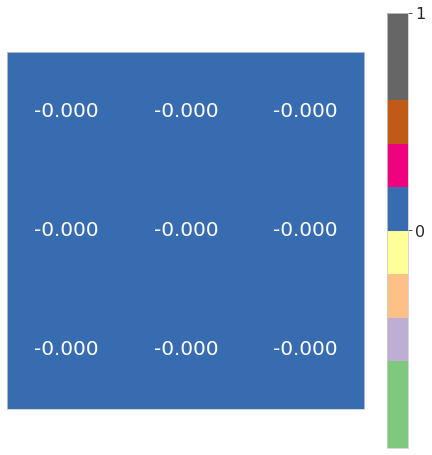

0 [0 0] -5e-44
1 [0 1] -2.783184e-29
2 [0 2] -5e-44
3 [1 0] -2.658e-42
4 [1 1] -2.34341e-39
5 [1 2] -1.6771656e-25
6 [2 0] -5e-44
7 [2 1] -5.2570058e-33
8 [2 2] -5e-44
0


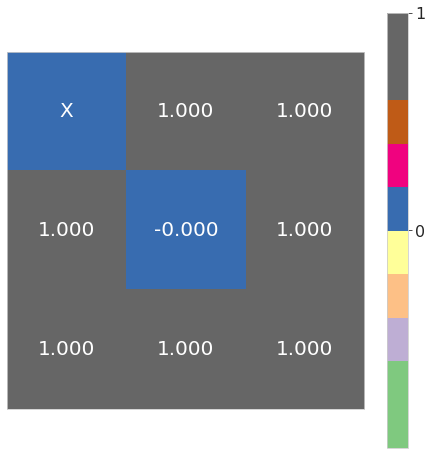

0 [0 1] 0.99999857
1 [0 2] 0.99999857
2 [1 0] 0.99999857
3 [1 1] -4.5e-44
4 [1 2] 0.99999857
5 [2 0] 0.99999857
6 [2 1] 0.99999857
7 [2 2] 0.99999857
3


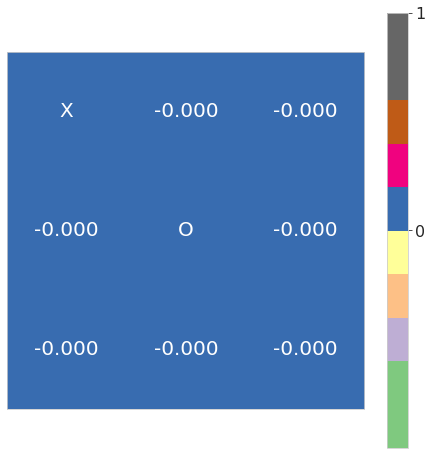

0 [0 1] -3.9e-44
1 [0 2] -3.9e-44
2 [1 0] -3.9e-44
3 [1 2] -8.953e-42
4 [2 0] -3.9e-44
5 [2 1] -4.16401e-40
6 [2 2] -3.9e-44
0


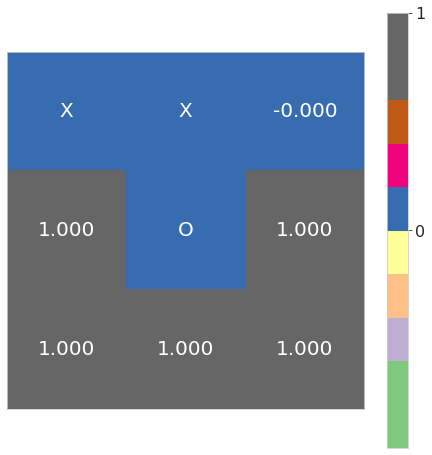

0 [0 2] -3.4e-44
1 [1 0] 0.9999995
2 [1 2] 0.9999995
3 [2 0] 0.9999995
4 [2 1] 0.9999995
5 [2 2] 0.9999995
0


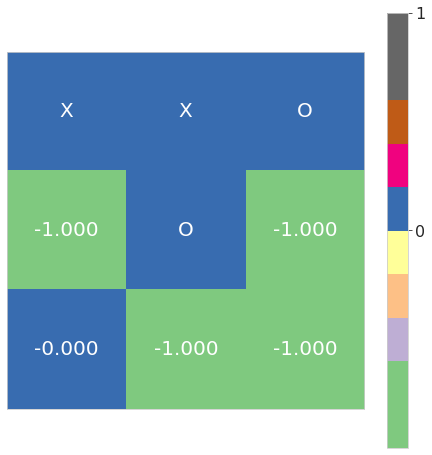

0 [1 0] -0.9999995
1 [1 2] -0.9999995
2 [2 0] -2.8e-44
3 [2 1] -0.9999995
4 [2 2] -0.9999995
2


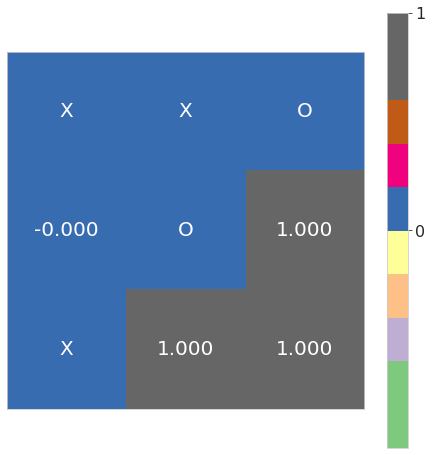

0 [1 0] -2.2e-44
1 [1 2] 0.9999995
2 [2 1] 0.9999995
3 [2 2] 0.9999995
0


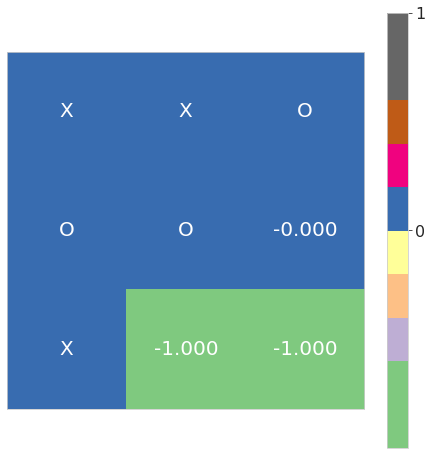

0 [1 2] -1.7e-44
1 [2 1] -0.9999995
2 [2 2] -0.9999995
0


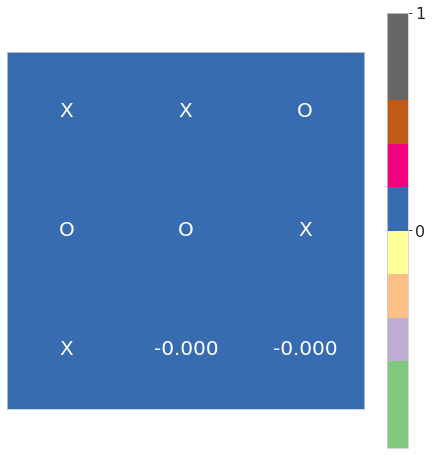

0 [2 1] -1.1e-44
1 [2 2] -1.1e-44
0


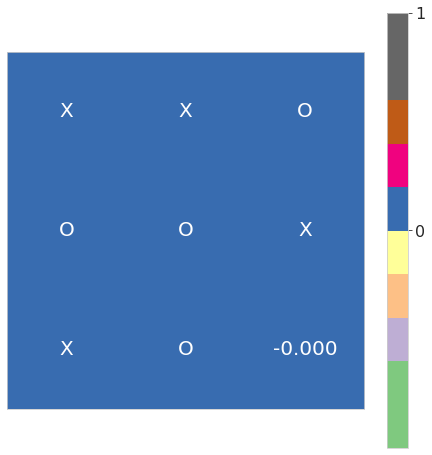

0 [2 2] -6e-45
0


In [19]:
# посмотрим на "идеальную" ничью
plot_test_game(env, pi, pi, random_crosses=False, random_naughts=False, verbose=True, fontx=20)

Дошли до полей побольше

In [20]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

[  172   373   610   887  1212  1592  2039  2562  3175  3893  4736  5723
  6880  8236  9826 11689 13873 16433 19433 22950 27072 31903 37566 44203
 51983 61101 71789 84316 99000]


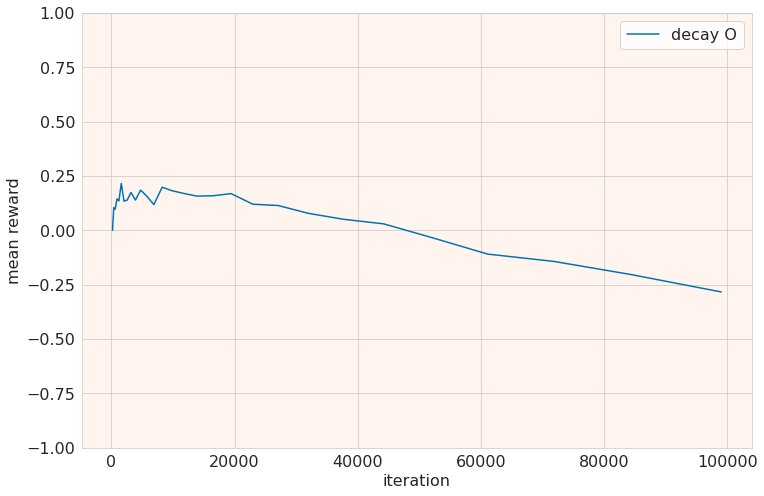

In [22]:
# на поле побольше Нолик будет играть по стратегии, а Крестик исследовать
x = (np.logspace(3, 5, 30).astype(np.int32) - 10**3)[1:]
print(x)

pi = Policy()
mean_rewards_o_decay = play_n_games(pi, x, const_gen(1), decay_epsilon_gen())

plot_reward([(x, mean_rewards_o_decay)], ['decay O'])

Улучшения есть =^_^= <br>
## Часть вторая

In [23]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [24]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        # exptuple = (prev_state, action, reward, next_state, player, done)
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [25]:
class Network(nn.Module): # общая стратегия для обоих игроков, игрок передается как фича
    def __init__(self, n_filters=384):
        nn.Module.__init__(self)
        self.conv = nn.Conv2d(1, n_filters, (3, 3))
        self.fc1 = nn.Linear(n_filters+1, n_filters//2)
        self.fc2 = nn.Linear(n_filters//2, 9)

    def forward(self, state, player):
        x = F.relu(self.conv(state))
        x = torch.flatten(x, 1)
        batch_size = x.size(0)
        x = torch.cat((x, player.view(batch_size, 1)), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
class TicTacToeDQN():
    def __init__(self, n_rows=3, n_cols=3, n_win=3):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model = Network()
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.004)
            
        self.steps_done = 0
        
        self.gamma = .8
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0
        
    def set_lr(self,lr):
        self.optimizer = optim.Adam(self.model.parameters(), lr)
    
    def select_greedy_action(self, state, player):
        if player.item() == 1.:
            return self.model(state, player).max(1)[1].view(1)
        elif player.item() == -1.:
            return self.model(state, player).min(1)[1].view(1)
        else:
            assert False # impossible
    
    def select_action(self, state, player):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            return self.select_greedy_action(state, player.unsqueeze(0).unsqueeze(0))
        else:
            return torch.tensor([[random.randrange(len(self.env.getEmptySpaces()))]], dtype=torch.int64)

    def play_episode(self, greedy_x=False, random_x=False,
                           greedy_o=False, random_o=False, verbose=False):
        self.model.eval()
        self.env.reset()
        
        player_x = torch.tensor(1., dtype=torch.float32)
        player_o = torch.tensor(-1., dtype=torch.float32)
        
        # state_before_x
        state = prev_state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
        assert tuple(prev_state.size()) == (1, 1, 3, 3) # (batch, ch, x, y)
        
        # ходит крестик
        assert self.env.curTurn == 1
        with torch.no_grad():
            player = player_x.detach().clone()
            if random_x:
                action_x = self.env.getEmptySpaces()[random.randrange(len(self.env.getEmptySpaces()))]
                action_x = torch.tensor(self.env.int_from_action(action_x)).view(1)            
            elif greedy_x:
                action_x = self.select_greedy_action(state, player)
            else:
                action_x = self.select_action(state, torch.ones(1)).view(1)
                # получили action уже тензором
        _, reward_x, done, _ = self.env.step(
                self.env.action_from_int(action_x.item()))
        if verbose:
            print(self.env.board)
        # state_after_x
        state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
        assert tuple(state.size()) == (1, 1, 3, 3) # (batch, ch, x, y)
        
        while not done:
            # ход Нолика
            if verbose:
                print('ходит Нолик')
            assert self.env.curTurn == -1
            player = player_o.detach().clone()
            with torch.no_grad():
                if random_o:
                    action_o = self.env.getEmptySpaces()[random.randrange(len(self.env.getEmptySpaces()))]
                    action_o = torch.tensor(self.env.int_from_action(action_o)).view(1)
                elif greedy_o:
                    action_o = self.select_greedy_action(state, player)
                else:
                    action_o = self.select_action(state, player).view(1)
                    # получили action уже тензором
            _, reward_o, done, _ = self.env.step(
                    self.env.action_from_int(action_o.item()))
            next_state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
            if verbose:
                print(self.env.board)
            # exptuple = (state_before_x, a_x, reward, state_after_o, player_x, done )
            exptuple = (
                prev_state.detach().clone(),
                action_x,
                torch.Tensor([reward_x + reward_o]),
                next_state, # один можно не клонировать
                player_x.detach().clone(),
                torch.BoolTensor([done])  
            # храним done чтобы не обязывать сеть в терминальных состояниях отвечать нулем
            )
            self.memory.store(exptuple)
            if done:
                exptuple = (
                    state.detach().clone(),
                    action_o,
                    torch.Tensor([reward_o]),
                    next_state,
                    player_o.detach().clone(),
                    torch.BoolTensor([True])              
                )
                self.memory.store(exptuple)
                break            
            
            prev_state, state = state, next_state
            
            # ходит Крестик
            if verbose:
                print('ходит Крестик')
            assert self.env.curTurn == 1
            player = player_x.detach().clone()
            with torch.no_grad():
                if random_x:
                    action_x = self.env.getEmptySpaces()[random.randrange(len(self.env.getEmptySpaces()))]
                    action_x = torch.tensor(self.env.int_from_action(action_x)).view(1)            
                elif greedy_x:
                    action_x = self.select_greedy_action(state, player)
                else:
                    action_x = self.select_action(state, player).view(1)
                    # получили action уже тензором
            _, reward_x, done, _ = self.env.step(
                self.env.action_from_int(action_x.item()))
            next_state = torch.Tensor(self.env.board).unsqueeze(0).unsqueeze(0)
            if verbose:
                print(self.env.board)
            # exptuple = (state_before_o, a_o, reward, state_after_x, player_o, done )
            exptuple = (
                prev_state.detach().clone(),
                action_o,
                torch.Tensor([reward_x + reward_o]),
                next_state,
                player_o.detach().clone(),
                torch.BoolTensor([done])
            )
            self.memory.store(exptuple)
            if done:
                exptuple = (
                    state.detach().clone(),
                    action_x,
                    torch.Tensor([reward_x]),
                    next_state,
                    player_x.detach().clone(),
                    torch.BoolTensor([True]) 
                )
                self.memory.store(exptuple)
                break
            
            prev_state, state = state, next_state
        return reward_x + reward_o
        
    def learn(self, batch_size):
        self.model.train()
        if len(self.memory) < batch_size:
            print('get more examples!')
            return

        # берём мини-батч из памяти
        exp_batch = list(zip(*self.memory.sample(batch_size)))
    
        
        batch_state = Variable(torch.cat(exp_batch[0]))
        batch_action = Variable(torch.stack(exp_batch[1]))
        batch_reward = Variable(torch.stack(exp_batch[2]))
        batch_next_state = Variable(torch.cat(exp_batch[3]))
        batch_player = Variable(torch.stack(exp_batch[4]))
        batch_done = Variable(torch.stack(exp_batch[5]))
        
        # считаем значения функции Q
        Q = self.model(batch_state, batch_player) \
                .gather(1, batch_action) \
                .reshape([batch_size])
        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state, batch_player).detach().max(1)[0]
        Qmin = self.model(batch_next_state, batch_player).detach().min(1)[0]
        assert batch_player.size() == Qmax.size() == Qmin.size()
        Qmm = torch.where(batch_player > 0, Qmax, Qmin).view(-1, 1) * self.gamma
        assert batch_done.size() == batch_reward.size() == Qmm.size()
        Qnext = torch.where(batch_done, batch_reward, Qmm).view(-1)
        
        # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.mse_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss
        

In [27]:
game = TicTacToeDQN()

In [28]:
# оцениваем Крестика
running_reward_x = 0
for _ in range(1000):
    running_reward_x += game.play_episode(greedy_x=True, random_o=True)
# оцениваем Нолика
running_reward_o = 0
for _ in range(1000):
    running_reward_o += game.play_episode(greedy_o=True, random_x=True)
# суммируем награду Крестика со знаком плюс, а Нолика со знаком минус
best_reward = running_reward_x/1000 - running_reward_o/1000 
print('initial reward: ', best_reward)
best_model = game.model.state_dict()

n_epochs = 50
for i in range(n_epochs):
    t0 = time.time()
    running_reward_o = 0
    running_reward_x = 0
    running_loss = 0
    # на каждую эпоху
    for _ in range(100):
        # 100 раз делаем это
        
        # повторяем 20 раз
        for _ in range(10): # играем 50 обычных эпизодов
            game.play_episode()
        #    5 эпизодов с параметрами
        running_reward_o += game.play_episode(greedy_o=True, random_x=True)
        running_reward_x += game.play_episode(random_o=True, greedy_x=True)
        game.play_episode(random_o=True)
        game.play_episode(random_x=True)
        game.play_episode(greedy_x=True, greedy_o=True)
        # учим
        running_loss += game.learn(512).item()
    
    reward = running_reward_x/100 - running_reward_o/100
    if reward > best_reward:
        best_model = game.model.state_dict()
    
    loss = running_loss/100
    print(f"epoch: {i} | reward: {reward:.3f} | loss: {loss:.3f} | {time.time()-t0:.1f} sec")

#torch.save(best_model, 'best_model.pth')

initial reward:  -5.95
epoch: 0 | reward: -5.920 | loss: 2.154 | 2.0 sec
epoch: 1 | reward: -5.660 | loss: 2.080 | 2.4 sec
epoch: 2 | reward: -5.060 | loss: 1.726 | 2.5 sec
epoch: 3 | reward: -4.850 | loss: 1.330 | 2.9 sec
epoch: 4 | reward: -4.190 | loss: 1.147 | 2.9 sec
epoch: 5 | reward: -3.210 | loss: 0.907 | 3.0 sec
epoch: 6 | reward: -2.540 | loss: 0.756 | 3.0 sec
epoch: 7 | reward: -2.180 | loss: 0.719 | 3.1 sec
epoch: 8 | reward: -1.790 | loss: 0.646 | 3.0 sec
epoch: 9 | reward: -0.910 | loss: 0.497 | 3.1 sec
epoch: 10 | reward: -0.060 | loss: 0.391 | 3.0 sec
epoch: 11 | reward: 0.420 | loss: 0.380 | 3.0 sec
epoch: 12 | reward: 0.360 | loss: 0.321 | 2.9 sec
epoch: 13 | reward: 0.740 | loss: 0.367 | 3.0 sec
epoch: 14 | reward: 0.600 | loss: 0.369 | 2.9 sec
epoch: 15 | reward: 0.730 | loss: 0.340 | 2.8 sec
epoch: 16 | reward: 1.010 | loss: 0.310 | 2.9 sec
epoch: 17 | reward: 0.820 | loss: 0.278 | 3.1 sec
epoch: 18 | reward: 1.290 | loss: 0.257 | 2.8 sec
epoch: 19 | reward: 0.930 

In [31]:
# загрузим лучший результат и уменьшим  lr
game.model.load_state_dict(best_model)
game.set_lr(.0005)

In [32]:
# обучаем также как и ранее
n_epochs = 50
for i in range(n_epochs):
    t0 = time.time()
    running_reward_o = 0
    running_reward_x = 0
    running_loss = 0
    # на каждую эпоху
    for _ in range(100):
        # 100 раз делаем это
        
        # повторяем 20 раз
        for _ in range(10): # играем 50 обычных эпизодов
            game.play_episode()
        #    5 эпизодов с параметрами
        running_reward_o += game.play_episode(greedy_o=True, random_x=True)
        running_reward_x += game.play_episode(random_o=True, greedy_x=True)
        game.play_episode(random_o=True)
        game.play_episode(random_x=True)
        game.play_episode(greedy_x=True, greedy_o=True)
        # учим
        running_loss += game.learn(512).item()
    
    reward = running_reward_x/100 - running_reward_o/100
    if reward > best_reward:
        best_model = game.model.state_dict()
    
    loss = running_loss/100
    print(f"epoch: {i} | reward: {reward:.3f} | loss: {loss:.3f} | {time.time()-t0:.1f} sec")

#torch.save(best_model, 'best_model.pth')

epoch: 0 | reward: 1.650 | loss: 0.208 | 3.4 sec
epoch: 1 | reward: 1.540 | loss: 0.260 | 3.4 sec
epoch: 2 | reward: 1.680 | loss: 0.263 | 3.4 sec
epoch: 3 | reward: 1.850 | loss: 0.208 | 3.4 sec
epoch: 4 | reward: 1.660 | loss: 0.175 | 3.4 sec
epoch: 5 | reward: 1.690 | loss: 0.185 | 3.4 sec
epoch: 6 | reward: 1.770 | loss: 0.190 | 3.4 sec
epoch: 7 | reward: 1.720 | loss: 0.173 | 3.4 sec
epoch: 8 | reward: 1.700 | loss: 0.207 | 3.3 sec
epoch: 9 | reward: 1.600 | loss: 0.186 | 3.4 sec
epoch: 10 | reward: 1.830 | loss: 0.182 | 3.3 sec
epoch: 11 | reward: 1.870 | loss: 0.183 | 3.3 sec
epoch: 12 | reward: 1.810 | loss: 0.150 | 3.4 sec
epoch: 13 | reward: 1.770 | loss: 0.201 | 3.3 sec
epoch: 14 | reward: 1.730 | loss: 0.195 | 3.3 sec
epoch: 15 | reward: 1.780 | loss: 0.176 | 3.3 sec
epoch: 16 | reward: 1.810 | loss: 0.164 | 3.3 sec
epoch: 17 | reward: 1.870 | loss: 0.188 | 3.3 sec
epoch: 18 | reward: 1.830 | loss: 0.199 | 3.3 sec
epoch: 19 | reward: 1.790 | loss: 0.187 | 3.3 sec
epoch: 20 

In [34]:
# оцениваем Крестика
running_reward_x = 0
for _ in range(5000):
    running_reward_x += game.play_episode(greedy_x=True, random_o=True)
# оцениваем Нолика
running_reward_o = 0
for _ in range(5000):
    running_reward_o += game.play_episode(greedy_o=True, random_x=True)
# суммируем награду Крестика со знаком плюс, а Нолика со знаком минус
 
print('best reward X: ', running_reward_x/5000, 'best reward O: ', running_reward_o/5000)

best reward X:  0.973 best reward O:  -0.8354


In [35]:
game.model.load_state_dict(best_model)

<All keys matched successfully>

In [36]:
# оцениваем Крестика
running_reward_x = 0
for _ in range(5000):
    running_reward_x += game.play_episode(greedy_x=True, random_o=True)
# оцениваем Нолика
running_reward_o = 0
for _ in range(5000):
    running_reward_o += game.play_episode(greedy_o=True, random_x=True)
# суммируем награду Крестика со знаком плюс, а Нолика со знаком минус
 
print('best reward X: ', running_reward_x/5000, 'best reward O: ', running_reward_o/5000)

best reward X:  0.9692 best reward O:  -0.8346


последняя эпоха оказалась возможно даже чуточку лучше чем "лучшая". Пока без использования Double и Duel. Проверим как они играют друг против друга:

In [37]:
game.play_episode(verbose=True)

[[1 0 0]
 [0 0 0]
 [0 0 0]]
ходит Нолик
[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0  0]]
ходит Крестик
[[ 1  0  0]
 [ 1 -1  0]
 [ 0  0  0]]
ходит Нолик
[[ 1  0  0]
 [ 1 -1  0]
 [-1  0  0]]
ходит Крестик
[[ 1  0  1]
 [ 1 -1  0]
 [-1  0  0]]
ходит Нолик
[[ 1 -1  1]
 [ 1 -1  0]
 [-1  0  0]]
ходит Крестик
[[ 1 -1  1]
 [ 1 -1  0]
 [-1  1  0]]
ходит Нолик
[[ 1 -1  1]
 [ 1 -1  0]
 [-1  1 -1]]
ходит Крестик
[[ 1 -1  1]
 [ 1 -1  1]
 [-1  1 -1]]


0

In [39]:
# оцениваем стратегии друг против друга:
running_reward = 0
for _ in range(5000):
    running_reward += game.play_episode()
 
print('best reward: ', running_reward/5000)

best reward:  -0.0896


Чем хорошо полученное решение - оба игрока играют по одной и той же модели, не нужно созадавать две.